In [17]:
!pip install tensorflow
!pip install tensorflow_datasets
!pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [18]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [19]:
import time
# Record the start time
start_time = time.time()
print(f"Notebook start time: {start_time:.2f}")

Notebook start time: 1706367091.33


In [20]:
import pathlib

base_dir = '/home/derrick/DataProjects/zindi-cgiar'
img_dir = os.path.join(base_dir, 'image_ds')

img_dir = pathlib.Path(img_dir)

In [21]:
BATCH_SIZE = 16
IMG_SIZE = (160, 160)

train_ds = tf.keras.utils.image_dataset_from_directory(
  img_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 2191 files belonging to 5 classes.
Using 1753 files for training.


In [22]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  img_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 2191 files belonging to 5 classes.
Using 438 files for validation.


In [23]:
class_names = train_ds.class_names

# Extract class names from the dataset
label_counts = {class_name: 0 for class_name in class_names}
# Iterate through the training dataset and count label occurrences
for _, labels in train_ds:
    for label in labels.numpy():
        class_name = class_names[label]
        label_counts[class_name] += 1

total_samples = sum(label_counts.values())

class_weights = dict()


# Calculate the class weights
for class_name, count in label_counts.items():
    print(f"Occurrences of {class_name}: {count}")
    class_weights[class_name] = total_samples / count
    

# Normalize class weights (0 - 1) 
class_weights_copy = dict()
total_class_weight = sum(class_weights.values())
for class_name, weight in class_weights.items():
    w = weight / total_class_weight
    class_weights[class_name] = w
    
    index = class_names.index(class_name)
    class_weights_copy[index] = w
    


print('============================================================================================================')
print('Handle imbalanced dataset by giving more weight to the minority class and less weight to the majority class.')
print('============================================================================================================')
print(class_weights)

# Replace labels with numerical indexes
class_weights = class_weights_copy

Occurrences of DR: 406
Occurrences of G: 393
Occurrences of ND: 213
Occurrences of WD: 402
Occurrences of other: 339
Handle imbalanced dataset by giving more weight to the minority class and less weight to the majority class.
{'DR': 0.1626870027389307, 'G': 0.16806850664632536, 'ND': 0.3100982305727975, 'WD': 0.16430577888558676, 'other': 0.19484048115635952}


In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print('Configure dataset for performance')

Configure dataset for performance


In [25]:
images = []
for label, _ in enumerate(class_names):
    # Get an image with numerical label
    filtered_dataset = train_ds.filter(lambda x, y: tf.math.equal(tf.argmax(y), label))
    image, _ = next(iter(filtered_dataset.take(1)))
    images.append((label, image[0]))
    
print('Collect images corresponding to all labels for preview')

Collect images corresponding to all labels for preview


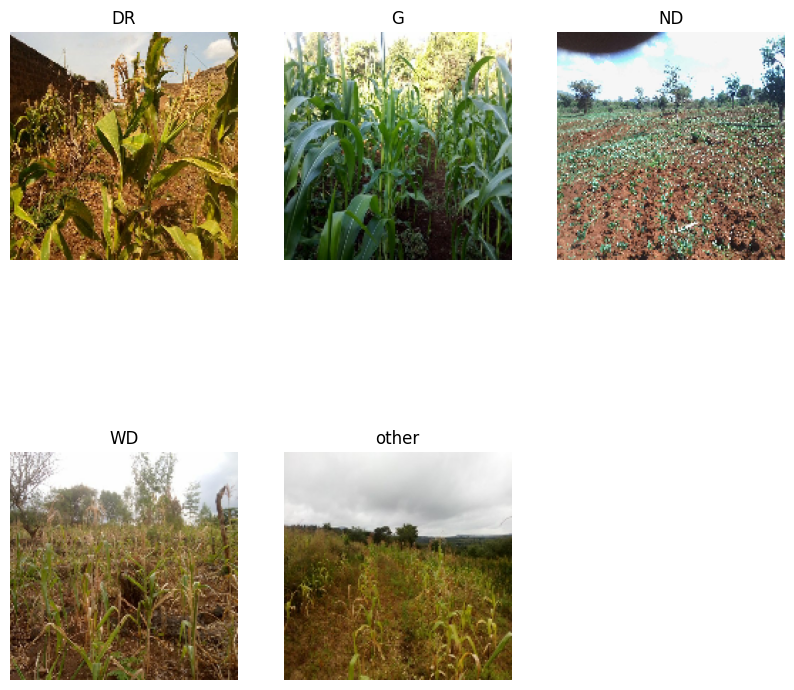

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(len(images)):
    img = images[i][1]
    title = class_names[images[i][0]]
    
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(title)
    plt.axis("off")

In [27]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 160, 160, 3)
(16,)


In [28]:
model = None

def get_fresh_model():
    resize_and_rescale = tf.keras.Sequential([
      tf.keras.layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
      tf.keras.layers.Rescaling(1./255)
    ])
    
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomFlip("horizontal_and_vertical"),
      tf.keras.layers.RandomRotation(0.2),
      tf.keras.layers.RandomContrast(factor=0.5),
      tf.keras.layers.RandomZoom(.5, .2),
    ])
    
    num_classes = len(class_names)

    return tf.keras.Sequential([
      resize_and_rescale,
      data_augmentation,
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(num_classes, activation='softmax')
    ])



In [29]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,),
                                                   include_top=False,
                                                   weights='imagenet')
def set_pretrained_model():
    # MobileNetV2 expects pixel values in [-1, 1], 
    # but at this point, the pixel values in your images are in [0, 255].
    # To rescale them, use the preprocessing method included with the model
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    
    # Create the base model from the pre-trained model MobileNet V2
    # Freeze all layers
    base_model.trainable = False 
    
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomFlip("horizontal_and_vertical"),
      tf.keras.layers.RandomRotation(0.2),
      tf.keras.layers.RandomContrast(factor=0.5)
    ])
    
    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    # training=False, freeze the BatchNormalization Layer
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)    
    outputs = tf.keras.layers.Dense(5)(x)
    
    return tf.keras.Model(inputs, outputs)
    

def finetune_pretrained_model():
    # Unfreeze the whole model
    base_model.trainable = True
    
    # Let's take a look to see how many layers are in the base model
    print("Number of layers in the base model: ", len(base_model.layers))
    
    # Fine-tune from this layer onwards
    fine_tune_at = 100
    
    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False


In [30]:
LR=0.003

# Prepare a directory to store all the checkpoints.
checkpoint_dir = os.path.join(base_dir, 'ckpt')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def init_model(option=None):
    global model
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints and option == 'resume_checkpoint':
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        model = tf.keras.models.load_model(latest_checkpoint)
        return
    elif option == 'pretrained':
        print("Set pretrained model")
        model = set_pretrained_model()
    elif option == 'finetune':
        print("Finetune pretrained model")
        finetune_pretrained_model() 
    else:
        model = get_fresh_model()
        
    model.compile(
      optimizer= tf.keras.optimizers.Adam(learning_rate=LR),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics='accuracy',
      run_eagerly=True
    )

init_model()

In [31]:
# print("No. of trainable variables: ", len(model.trainable_variables))

## Experiments

- scratch: A model created from scratch
- pre-trained: A pre-trained model finetuned for our usecase

They will have separate checkpoint directory

In [ ]:
experiment = 'scratch'

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 10 epochs"
        patience=1000,
        verbose=1,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath= os.path.join(checkpoint_dir, experiment, "mymodel_{epoch}"),
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )
]

initial_epochs = 10000

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=initial_epochs,
  # class_weight=class_weights,
  callbacks=callbacks
)

print('Train model')

Epoch 1/10000
110/110 [==============================] - ETA: 0s - loss: 1.6515 - accuracy: 0.2447
Epoch 1: val_loss improved from inf to 1.59548, saving model to /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_1
INFO:tensorflow:Assets written to: /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_1/assets


INFO:tensorflow:Assets written to: /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_1/assets


110/110 [==============================] - 34s 302ms/step - loss: 1.6515 - accuracy: 0.2447 - val_loss: 1.5955 - val_accuracy: 0.2146
Epoch 2/10000
110/110 [==============================] - ETA: 0s - loss: 1.5882 - accuracy: 0.2230
Epoch 2: val_loss did not improve from 1.59548
110/110 [==============================] - 31s 278ms/step - loss: 1.5882 - accuracy: 0.2230 - val_loss: 1.5972 - val_accuracy: 0.2146
Epoch 3/10000
110/110 [==============================] - ETA: 0s - loss: 1.5897 - accuracy: 0.2191
Epoch 3: val_loss improved from 1.59548 to 1.59502, saving model to /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_3
INFO:tensorflow:Assets written to: /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_3/assets


INFO:tensorflow:Assets written to: /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_3/assets


110/110 [==============================] - 33s 301ms/step - loss: 1.5897 - accuracy: 0.2191 - val_loss: 1.5950 - val_accuracy: 0.2146
Epoch 4/10000
110/110 [==============================] - ETA: 0s - loss: 1.5882 - accuracy: 0.2270
Epoch 4: val_loss did not improve from 1.59502
110/110 [==============================] - 31s 284ms/step - loss: 1.5882 - accuracy: 0.2270 - val_loss: 1.5951 - val_accuracy: 0.2146
Epoch 5/10000
110/110 [==============================] - ETA: 0s - loss: 1.5871 - accuracy: 0.2310
Epoch 5: val_loss improved from 1.59502 to 1.59483, saving model to /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_5
INFO:tensorflow:Assets written to: /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_5/assets


INFO:tensorflow:Assets written to: /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_5/assets


110/110 [==============================] - 32s 287ms/step - loss: 1.5871 - accuracy: 0.2310 - val_loss: 1.5948 - val_accuracy: 0.2146
Epoch 6/10000
110/110 [==============================] - ETA: 0s - loss: 1.5880 - accuracy: 0.2253
Epoch 6: val_loss did not improve from 1.59483
110/110 [==============================] - 32s 290ms/step - loss: 1.5880 - accuracy: 0.2253 - val_loss: 1.5950 - val_accuracy: 0.2146
Epoch 7/10000
110/110 [==============================] - ETA: 0s - loss: 1.5879 - accuracy: 0.2253
Epoch 7: val_loss improved from 1.59483 to 1.59445, saving model to /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_7
INFO:tensorflow:Assets written to: /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_7/assets


INFO:tensorflow:Assets written to: /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_7/assets


110/110 [==============================] - 35s 320ms/step - loss: 1.5879 - accuracy: 0.2253 - val_loss: 1.5944 - val_accuracy: 0.2146
Epoch 8/10000
110/110 [==============================] - ETA: 0s - loss: 1.5875 - accuracy: 0.2248
Epoch 8: val_loss improved from 1.59445 to 1.59423, saving model to /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_8
INFO:tensorflow:Assets written to: /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_8/assets


INFO:tensorflow:Assets written to: /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_8/assets


110/110 [==============================] - 35s 318ms/step - loss: 1.5875 - accuracy: 0.2248 - val_loss: 1.5942 - val_accuracy: 0.2146
Epoch 9/10000
110/110 [==============================] - ETA: 0s - loss: 1.5875 - accuracy: 0.2219
Epoch 9: val_loss improved from 1.59423 to 1.59390, saving model to /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_9
INFO:tensorflow:Assets written to: /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_9/assets


INFO:tensorflow:Assets written to: /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_9/assets


110/110 [==============================] - 35s 317ms/step - loss: 1.5875 - accuracy: 0.2219 - val_loss: 1.5939 - val_accuracy: 0.2146
Epoch 10/10000
110/110 [==============================] - ETA: 0s - loss: 1.5873 - accuracy: 0.2288
Epoch 10: val_loss did not improve from 1.59390
110/110 [==============================] - 34s 304ms/step - loss: 1.5873 - accuracy: 0.2288 - val_loss: 1.5941 - val_accuracy: 0.2146
Epoch 11/10000
110/110 [==============================] - ETA: 0s - loss: 1.5871 - accuracy: 0.2288
Epoch 11: val_loss did not improve from 1.59390
110/110 [==============================] - 33s 299ms/step - loss: 1.5871 - accuracy: 0.2288 - val_loss: 1.5943 - val_accuracy: 0.2146
Epoch 12/10000
110/110 [==============================] - ETA: 0s - loss: 1.5883 - accuracy: 0.2230
Epoch 12: val_loss did not improve from 1.59390
110/110 [==============================] - 34s 307ms/step - loss: 1.5883 - accuracy: 0.2230 - val_loss: 1.5949 - val_accuracy: 0.2146
Epoch 13/10000
110/1

INFO:tensorflow:Assets written to: /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_13/assets


110/110 [==============================] - 35s 317ms/step - loss: 1.5877 - accuracy: 0.2139 - val_loss: 1.5934 - val_accuracy: 0.2146
Epoch 14/10000
110/110 [==============================] - ETA: 0s - loss: 1.5875 - accuracy: 0.2208
Epoch 14: val_loss did not improve from 1.59345
110/110 [==============================] - 33s 297ms/step - loss: 1.5875 - accuracy: 0.2208 - val_loss: 1.5946 - val_accuracy: 0.2146
Epoch 15/10000
110/110 [==============================] - ETA: 0s - loss: 1.5871 - accuracy: 0.2105
Epoch 15: val_loss did not improve from 1.59345
110/110 [==============================] - 34s 305ms/step - loss: 1.5871 - accuracy: 0.2105 - val_loss: 1.5938 - val_accuracy: 0.2146
Epoch 16/10000
110/110 [==============================] - ETA: 0s - loss: 1.5868 - accuracy: 0.2230
Epoch 16: val_loss did not improve from 1.59345
110/110 [==============================] - 33s 302ms/step - loss: 1.5868 - accuracy: 0.2230 - val_loss: 1.5936 - val_accuracy: 0.2146
Epoch 17/10000
110/1

INFO:tensorflow:Assets written to: /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_17/assets


110/110 [==============================] - 34s 311ms/step - loss: 1.5867 - accuracy: 0.2162 - val_loss: 1.5934 - val_accuracy: 0.2146
Epoch 18/10000
110/110 [==============================] - ETA: 0s - loss: 1.5873 - accuracy: 0.2208
Epoch 18: val_loss did not improve from 1.59345
110/110 [==============================] - 34s 309ms/step - loss: 1.5873 - accuracy: 0.2208 - val_loss: 1.5937 - val_accuracy: 0.2146
Epoch 19/10000
110/110 [==============================] - ETA: 0s - loss: 1.5864 - accuracy: 0.2248
Epoch 19: val_loss did not improve from 1.59345
110/110 [==============================] - 34s 307ms/step - loss: 1.5864 - accuracy: 0.2248 - val_loss: 1.5935 - val_accuracy: 0.2146
Epoch 20/10000
110/110 [==============================] - ETA: 0s - loss: 1.5874 - accuracy: 0.2145
Epoch 20: val_loss improved from 1.59345 to 1.59320, saving model to /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_20
INFO:tensorflow:Assets written to: /home/derrick/DataProjects/zindi-cg

INFO:tensorflow:Assets written to: /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_20/assets


110/110 [==============================] - 35s 316ms/step - loss: 1.5874 - accuracy: 0.2145 - val_loss: 1.5932 - val_accuracy: 0.2146
Epoch 21/10000
110/110 [==============================] - ETA: 0s - loss: 1.5865 - accuracy: 0.2288
Epoch 21: val_loss did not improve from 1.59320
110/110 [==============================] - 34s 305ms/step - loss: 1.5865 - accuracy: 0.2288 - val_loss: 1.5945 - val_accuracy: 0.2146
Epoch 22/10000
110/110 [==============================] - ETA: 0s - loss: 1.5871 - accuracy: 0.2265
Epoch 22: val_loss did not improve from 1.59320
110/110 [==============================] - 34s 305ms/step - loss: 1.5871 - accuracy: 0.2265 - val_loss: 1.5938 - val_accuracy: 0.2146
Epoch 23/10000
110/110 [==============================] - ETA: 0s - loss: 1.5866 - accuracy: 0.2230
Epoch 23: val_loss did not improve from 1.59320
110/110 [==============================] - 33s 295ms/step - loss: 1.5866 - accuracy: 0.2230 - val_loss: 1.5936 - val_accuracy: 0.2146
Epoch 24/10000
110/1

INFO:tensorflow:Assets written to: /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_38/assets


110/110 [==============================] - 35s 316ms/step - loss: 1.5868 - accuracy: 0.2265 - val_loss: 1.5931 - val_accuracy: 0.2146
Epoch 39/10000
110/110 [==============================] - ETA: 0s - loss: 1.5865 - accuracy: 0.2213
Epoch 39: val_loss did not improve from 1.59315
110/110 [==============================] - 34s 304ms/step - loss: 1.5865 - accuracy: 0.2213 - val_loss: 1.5937 - val_accuracy: 0.2146
Epoch 40/10000
110/110 [==============================] - ETA: 0s - loss: 1.5866 - accuracy: 0.2094
Epoch 40: val_loss did not improve from 1.59315
110/110 [==============================] - 34s 304ms/step - loss: 1.5866 - accuracy: 0.2094 - val_loss: 1.5932 - val_accuracy: 0.2146
Epoch 41/10000
110/110 [==============================] - ETA: 0s - loss: 1.5867 - accuracy: 0.2236
Epoch 41: val_loss did not improve from 1.59315
110/110 [==============================] - 34s 304ms/step - loss: 1.5867 - accuracy: 0.2236 - val_loss: 1.5933 - val_accuracy: 0.2146
Epoch 42/10000
110/1

INFO:tensorflow:Assets written to: /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_48/assets


110/110 [==============================] - 35s 318ms/step - loss: 1.5866 - accuracy: 0.2242 - val_loss: 1.5931 - val_accuracy: 0.2146
Epoch 49/10000
110/110 [==============================] - ETA: 0s - loss: 1.5861 - accuracy: 0.2259
Epoch 49: val_loss did not improve from 1.59306
110/110 [==============================] - 34s 304ms/step - loss: 1.5861 - accuracy: 0.2259 - val_loss: 1.5932 - val_accuracy: 0.2146
Epoch 50/10000
110/110 [==============================] - ETA: 0s - loss: 1.5866 - accuracy: 0.2185
Epoch 50: val_loss did not improve from 1.59306
110/110 [==============================] - 34s 304ms/step - loss: 1.5866 - accuracy: 0.2185 - val_loss: 1.5934 - val_accuracy: 0.2146
Epoch 51/10000
110/110 [==============================] - ETA: 0s - loss: 1.5864 - accuracy: 0.2202
Epoch 51: val_loss did not improve from 1.59306
110/110 [==============================] - 34s 305ms/step - loss: 1.5864 - accuracy: 0.2202 - val_loss: 1.5935 - val_accuracy: 0.2146
Epoch 52/10000
110/1

INFO:tensorflow:Assets written to: /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_56/assets


110/110 [==============================] - 35s 318ms/step - loss: 1.5863 - accuracy: 0.2191 - val_loss: 1.5930 - val_accuracy: 0.2146
Epoch 57/10000
110/110 [==============================] - ETA: 0s - loss: 1.5863 - accuracy: 0.2219
Epoch 57: val_loss did not improve from 1.59305
110/110 [==============================] - 33s 302ms/step - loss: 1.5863 - accuracy: 0.2219 - val_loss: 1.5932 - val_accuracy: 0.2146
Epoch 58/10000
110/110 [==============================] - ETA: 0s - loss: 1.5863 - accuracy: 0.2276
Epoch 58: val_loss improved from 1.59305 to 1.59303, saving model to /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_58
INFO:tensorflow:Assets written to: /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_58/assets


INFO:tensorflow:Assets written to: /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_58/assets


110/110 [==============================] - 34s 306ms/step - loss: 1.5863 - accuracy: 0.2276 - val_loss: 1.5930 - val_accuracy: 0.2146
Epoch 59/10000
110/110 [==============================] - ETA: 0s - loss: 1.5863 - accuracy: 0.2265
Epoch 59: val_loss did not improve from 1.59303
110/110 [==============================] - 34s 303ms/step - loss: 1.5863 - accuracy: 0.2265 - val_loss: 1.5930 - val_accuracy: 0.2146
Epoch 60/10000
110/110 [==============================] - ETA: 0s - loss: 1.5864 - accuracy: 0.2219
Epoch 60: val_loss did not improve from 1.59303
110/110 [==============================] - 33s 299ms/step - loss: 1.5864 - accuracy: 0.2219 - val_loss: 1.5931 - val_accuracy: 0.2146
Epoch 61/10000
110/110 [==============================] - ETA: 0s - loss: 1.5863 - accuracy: 0.2248
Epoch 61: val_loss did not improve from 1.59303
110/110 [==============================] - 32s 292ms/step - loss: 1.5863 - accuracy: 0.2248 - val_loss: 1.5931 - val_accuracy: 0.2146
Epoch 62/10000
110/1

INFO:tensorflow:Assets written to: /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_91/assets


110/110 [==============================] - 33s 302ms/step - loss: 1.5861 - accuracy: 0.2179 - val_loss: 1.5930 - val_accuracy: 0.2146
Epoch 92/10000
110/110 [==============================] - ETA: 0s - loss: 1.5862 - accuracy: 0.2236
Epoch 92: val_loss did not improve from 1.59300
110/110 [==============================] - 34s 310ms/step - loss: 1.5862 - accuracy: 0.2236 - val_loss: 1.5931 - val_accuracy: 0.2146
Epoch 93/10000
110/110 [==============================] - ETA: 0s - loss: 1.5860 - accuracy: 0.2270
Epoch 93: val_loss did not improve from 1.59300
110/110 [==============================] - 33s 302ms/step - loss: 1.5860 - accuracy: 0.2270 - val_loss: 1.5933 - val_accuracy: 0.2146
Epoch 94/10000
110/110 [==============================] - ETA: 0s - loss: 1.5860 - accuracy: 0.2236
Epoch 94: val_loss did not improve from 1.59300
110/110 [==============================] - 34s 310ms/step - loss: 1.5860 - accuracy: 0.2236 - val_loss: 1.5933 - val_accuracy: 0.2146
Epoch 95/10000
110/1

INFO:tensorflow:Assets written to: /home/derrick/DataProjects/zindi-cgiar/ckpt/scratch/mymodel_129/assets


110/110 [==============================] - 35s 319ms/step - loss: 1.5861 - accuracy: 0.2225 - val_loss: 1.5929 - val_accuracy: 0.2146
Epoch 130/10000
110/110 [==============================] - ETA: 0s - loss: 1.5862 - accuracy: 0.2213
Epoch 130: val_loss did not improve from 1.59293
110/110 [==============================] - 34s 309ms/step - loss: 1.5862 - accuracy: 0.2213 - val_loss: 1.5933 - val_accuracy: 0.2146
Epoch 131/10000
110/110 [==============================] - ETA: 0s - loss: 1.5860 - accuracy: 0.2213
Epoch 131: val_loss did not improve from 1.59293
110/110 [==============================] - 34s 308ms/step - loss: 1.5860 - accuracy: 0.2213 - val_loss: 1.5933 - val_accuracy: 0.2146
Epoch 132/10000
110/110 [==============================] - ETA: 0s - loss: 1.5861 - accuracy: 0.2219
Epoch 132: val_loss did not improve from 1.59293
110/110 [==============================] - 34s 310ms/step - loss: 1.5861 - accuracy: 0.2219 - val_loss: 1.5933 - val_accuracy: 0.2146
Epoch 133/1000

In [ ]:
# init_model(option='finetune')

# finetune_epochs = 50 + initial_epochs

# model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=finetune_epochs,
#   class_weight=class_weights,
#   callbacks=callbacks
# )

# print('Train finetuned model')

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = os.path.join(base_dir, 'test_dir')
# Create an ImageDataGenerator for test data
test_data_gen = ImageDataGenerator(rescale=1./255)
test_data = test_data_gen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,  # Adjust the target size based on your model requirements
    batch_size=BATCH_SIZE,
    classes=['.'],
    class_mode='categorical',  # Set to None for regression tasks; 'categorical' or 'binary' for classification
    shuffle=False  # Ensure the order of predictions matches the order of files
)

# Obtain predictions
predictions = model.predict(test_data)
print("predictions shape:", predictions.shape)

In [ ]:
# Assuming the filenames in the test directory are stored in test_data.filenames
# Create a DataFrame with filenames and corresponding predictions
result_df = pd.DataFrame(predictions, columns=['DR', 'G', 'ND', 'WD', 'other'])
result_df['ID'] = test_data.filenames
result_df['ID'] = result_df['ID'].apply(lambda x: x.split('.')[1].replace('/',''))
# Re-order columns
new_column_order = ['ID', 'DR', 'G', 'ND', 'WD', 'other']
result_df = result_df[new_column_order]
# Save the DataFrame to a CSV file
result_df.to_csv(f'{base_dir}/predictions.csv', index=False)
result_df

In [ ]:
# Record the end time
end_time = time.time()

# Calculate the total runtime
total_runtime = end_time - start_time

# Output the total runtime
print(f"Total notebook runtime: {total_runtime:.2f} seconds")